# Random forest predictions
This notebook ingests the positive and negative training vectors as well as positive and negative validation sets as generated by the notebook ``ExtractDifferenceVectorsHistoricalLaterYear.ipynb``.Positive and training datasets are obtained up to the taregt year. Positive and negative validation sets are obtained for a specific year which is at least one year after the target year.

In [1]:
import pandas as pd
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KcetParser
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import matplotlib
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import precision_score, recall_score


number of positive training links upto 2014: 246
number of negative training links upto 2014: 2231
number of positive validation links 1 years after 2014 : 1314
number of negative validation links 1 years after 2014 : 2231
Total training vectors: 2477
Total training labels: 2477
Total test vectors: 3563
Total test labels: 3563
{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; t

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.7s
Best Threshold for auc=0.06501, G-Mean=0.788
[[2260   14]
 [2318  566]]
Best Threshold for pr =0.03066, F-Score=0.824
precision=0.98, recall=0.20


number of positive training links upto 2014: 246
number of negative training links upto 2014: 2231
number of positive validation links 5 years after 2014 : 3179
number of negative validation links 5 years after 2014 : 2231
Total training vectors: 2477
Total training labels: 2477
Total test vectors: 5424
Total test labels: 5424
{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estima

/Users/ravanv/PycharmProjects/KCET/kcet_env/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


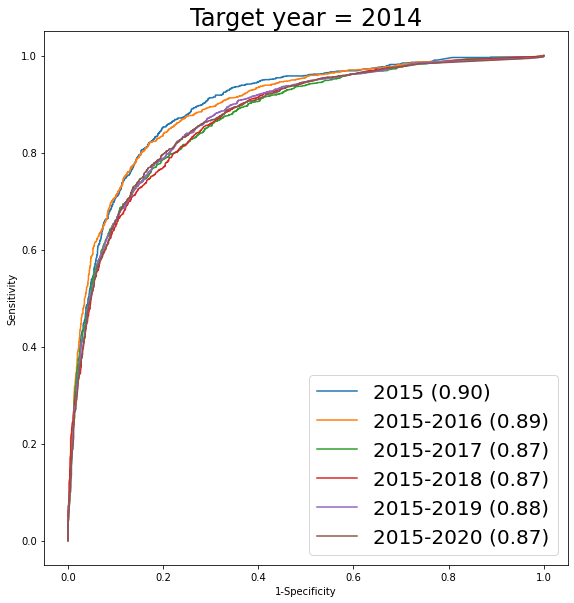

In [2]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
fig.tight_layout()
font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

target_year = 2014

for num_years_later in range(1,7):
    positive_validation_pickle_path = "positive-valid-vectors-{}-years-after-{}.pkl".format(num_years_later,target_year)
    negative_validation_pickle_path = "negative-valid-vectors-{}-years-after-{}.pkl".format(num_years_later, target_year)
    positive_train_pickle_path = "positive-train-vectors-{}.pkl".format(target_year)
    negative_train_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
    diff_vectors_pos_validation = pd.read_pickle(positive_validation_pickle_path)
    diff_vectors_neg_validation = pd.read_pickle(negative_validation_pickle_path)
    diff_vectors_pos_training = pd.read_pickle(positive_train_pickle_path)
    diff_vectors_neg_training = pd.read_pickle(negative_train_pickle_path)
    print("number of positive training links upto {}: {}".format(target_year,diff_vectors_pos_training.shape[0]))
    print("number of negative training links upto {}: {}".format(target_year,diff_vectors_neg_training.shape[0]))
    print("number of positive validation links {} years after {} : {}".format(num_years_later, target_year, diff_vectors_pos_validation.shape[0]))
    print("number of negative validation links {} years after {} : {}".format(num_years_later, target_year, diff_vectors_neg_training.shape[0]))
    
    X_train = pd.concat([diff_vectors_pos_training,diff_vectors_neg_training])
    print("Total training vectors: %d" % len(X_train))
    
    label_1 = np.ones(diff_vectors_pos_training.shape[0])
    label_0 = np.zeros(diff_vectors_neg_training.shape[0])
    y_train = np.concatenate((label_1,label_0))
    print("Total training labels: %d" % len(y_train))
    
    X_test = pd.concat([diff_vectors_pos_validation,diff_vectors_neg_validation])
    print("Total test vectors: %d" % len(X_test))
    
    label_1 = np.ones(diff_vectors_pos_validation.shape[0])
    label_0 = np.zeros(diff_vectors_neg_validation.shape[0])
    y_test = np.concatenate((label_1,label_0))
    print("Total test labels: %d" % len(y_test))
    
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    #Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 3, 5, 7, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    print(random_grid)
    
    
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 10, verbose=2, random_state=42)

    rf_random.fit(X_train,y_train)

    best_model = rf_random.best_estimator_
    
    
    y_pred = best_model.predict(X_test)
    yproba = best_model.predict_proba(X_test)[::,1]
    
    fpr, tpr, thresholds_auc = roc_curve(y_test,  yproba)
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix_gmeans = argmax(gmeans)
    print('Best Threshold for auc=%.5f, G-Mean=%.3f' % (thresholds_auc[ix_gmeans], gmeans[ix_gmeans]))
    
    
    print(metrics.confusion_matrix(y_test,y_pred))
    auc_roc = roc_auc_score(y_test, yproba)
    if num_years_later == 1:
        ax1.plot(fpr, tpr, label='2015 (%0.2f)' %(auc_roc))
        #ax1.scatter(fpr[ix_gmeans], tpr[ix_gmeans], marker='o', color='black', label='Best')

    else:
        ax1.plot(fpr, tpr, label='2015-%d (%0.2f)' %(num_years_later +target_year  ,auc_roc))
        #ax1.scatter(fpr[ix_gmeans], tpr[ix_gmeans], marker='o', color='black')
        
        
    precision, recall, thresholds_pr = precision_recall_curve(y_test, yproba)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix_fscore = argmax(fscore)
    print('Best Threshold for pr =%.5f, F-Score=%.3f' % (thresholds_pr[ix_fscore], fscore[ix_fscore]))
    precision_best_threshold = precision_score(y_test, y_pred > thresholds_pr[ix_fscore])
    recall_best_threshold = recall_score(y_test, y_pred > thresholds_pr[ix_fscore])
    print('precision=%.2f, recall=%.2f\n\n' % (precision_best_threshold, recall_best_threshold))
    
    #ax2.plot(recall, precision, label='%d year(s) after %d, precision-recall (area = %0.2f)' % (num_years_later,target_year, auc_recall_precision))
    ax1.set_title('Target year = 2014')
    ax1.set_xlabel('1-Specificity')
    ax1.set_ylabel('Sensitivity')
    ax1.legend(loc="lower right")
    
fig.show()

    